In [1]:
%load_ext autoreload
%autoreload 2

# Loading Classes For Model and Dataset

In [2]:
%run Model.ipynb

In [1108]:
%run NimbroDataLoader-RGB.ipynb

In [4]:
%run NimbroSegmentDataLoader.ipynb

# Loading Blob Dataset

In [5]:
dataset1 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTest/',image_size=(HEIGHT,WIDTH))

dataset2 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTrain/',image_size=(HEIGHT,WIDTH))

dataset3 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/dataset/',image_size=(HEIGHT,WIDTH))

In [6]:
batch_size = 16

In [7]:
dataset = ConcatDataset([dataset1,dataset2,dataset3])
len(dataset)

8868

## Sample Dataset from Blobs

In [8]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

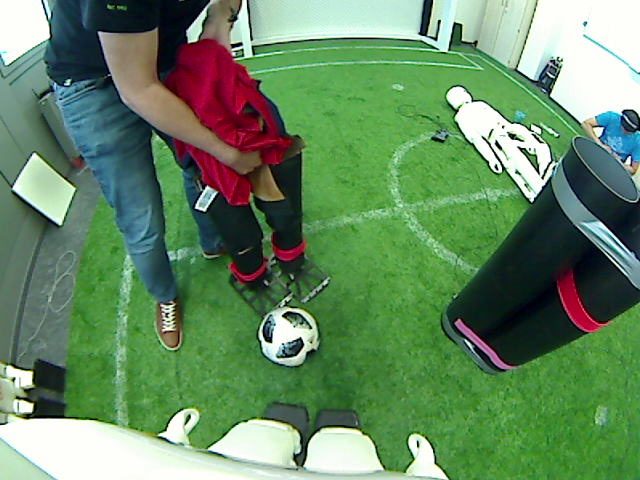

In [9]:
TF.to_pil_image(invTrans(dataset1[1][0]))

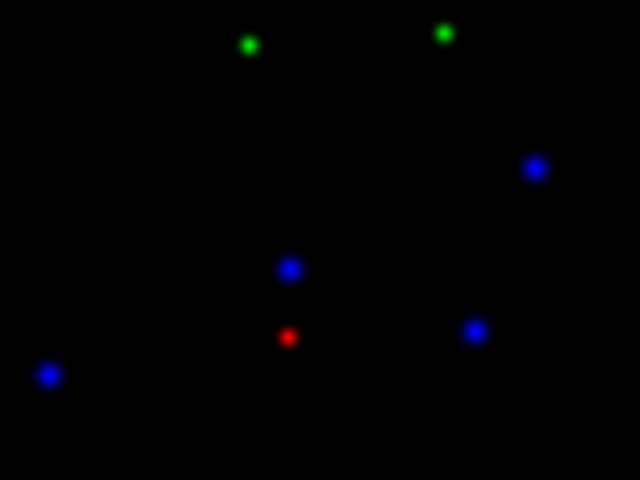

In [11]:
TF.resize(TF.to_pil_image(dataset1[1][1]),(480,640))

## Train Test split for Blobs

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [8100,len(dataset)-8100])

In [13]:
train_blob_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)
val_blob_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

# Loading Segmentation Dataset

In [14]:
dataset_seg_1 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/forceTrain/',(HEIGHT,WIDTH))
dataset_seg_2 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/dataset/',(HEIGHT,WIDTH))

dataset_seg = ConcatDataset([dataset_seg_1,dataset_seg_2])
len(dataset_seg)

1192

## Sample from Segmentation

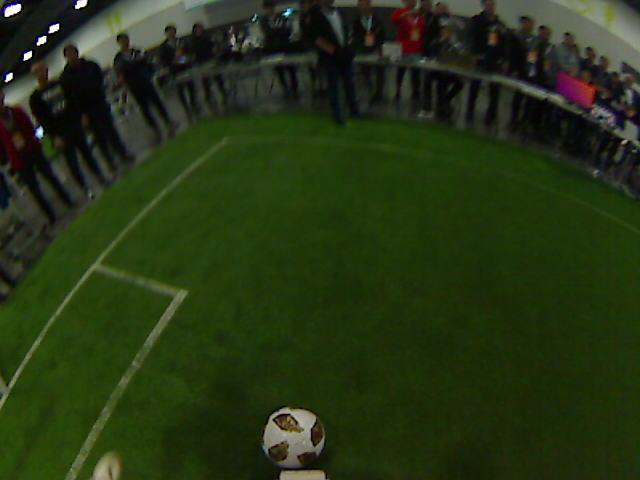

In [15]:
TF.to_pil_image(invTrans(dataset_seg_1[50][0]))

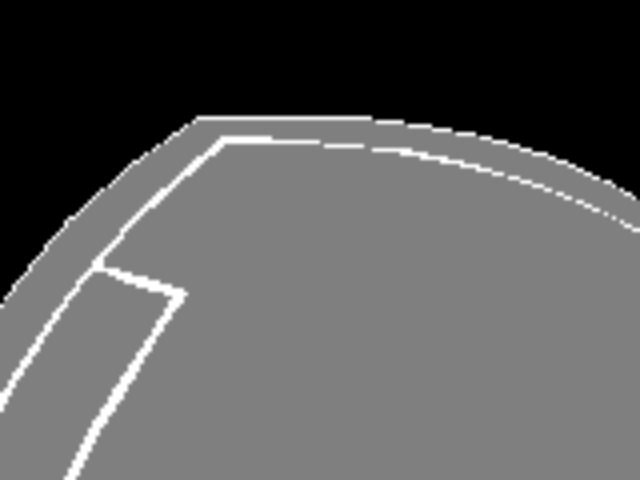

In [16]:
TF.resize(TF.to_pil_image(dataset_seg_1[50][1]/2),(480,640))

## Batching and loading segmentation dataset

In [17]:
train_seg_dataset, test_seg_dataset = torch.utils.data.random_split(dataset_seg, [1050,len(dataset_seg)-1050])
train_seg_loader = torch.utils.data.DataLoader(dataset=train_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)

In [18]:
val_seg_loader = torch.utils.data.DataLoader(dataset=test_seg_dataset, 
                               batch_size=1, 
                               shuffle=False)

# Optimiser and Network objects

In [19]:
n_epochs = 10
lr = 0.001
nimbro_net = NimbroNet18()
optimizer = torch.optim.Adam(nimbro_net.parameters(), lr=lr, betas=(0.5, 0.999))

In [20]:
nimbro_net.cuda()

NimbroNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

# Loss function for training

In [21]:
criterion_cross_ent = nn.CrossEntropyLoss()

def mse_loss_fn(y_hat,y):
    return ((y - y_hat)**2).sum()/y.shape[0]

def total_variation_loss(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [22]:
train_losses = []
val_losses = []

# Training Loop

In [ ]:
nimbro_net.train()
var_loss_weight1 = 0.0000005
var_loss_weight2 = 0.0000001
# mse_loss_weight = 20
for epoch in range(80):
    for batch_id in range(500):
        images, target = next(iter(train_blob_loader))  

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        
        if torch.cuda.is_available():
            images = images.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        _,blob = nimbro_net(images)
        
        ttl_var_blob = total_variation_loss(blob)*var_loss_weight1
        mse_loss = mse_loss_fn(blob, target)
        blob_loss = ttl_var_blob + mse_loss
        blob_loss.backward()
        
        optimizer.step()
        
        images, target_seg = next(iter(train_seg_loader))  
        if torch.cuda.is_available():
            images = images.cuda()
            target_seg = target_seg.cuda()
            
        optimizer.zero_grad()
        seg,_ = nimbro_net(images)

        ttl_var_seg = total_variation_loss(seg[:,[0,1],:,:])*var_loss_weight2
        cross_loss = criterion_cross_ent(seg,target_seg.long())
        seg_loss = cross_loss + ttl_var_seg
        seg_loss.backward()
        
        train_losses.append((mse_loss,ttl_var_blob,cross_loss,ttl_var_seg))
        optimizer.step()
        
    print(f'Epoch:{epoch} Train MSE: {mse_loss.item():.3f}\t\tCross Entropy: {cross_loss.item():.3f}')
    print(f'\tVariance Loss Blobs:{ttl_var_blob:.2}\tVariance Loss Seg:{ttl_var_seg:.3}')

    
    nimbro_net.eval()
    with torch.no_grad():
        val_loss = 0
        seg_loss = 0
        tot_var_loss_blob = 0
        tot_var_loss_seg = 0

        for k,(images, target) in enumerate(val_blob_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            _,blob = nimbro_net(images)
            val_loss +=   (mse_loss_fn(blob,target).item()-val_loss)/(k+1)
            tot_var_loss_blob += (total_variation_loss(blob) - tot_var_loss_blob)/(k+1)

        for k,(images, target) in enumerate(val_seg_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            seg,_ = nimbro_net(images)
            seg_loss +=   (criterion_cross_ent(seg,target.long()).item()-seg_loss)/(k+1)
            tot_var_loss_seg += (total_variation_loss(seg[:,[0,1],:,:]) - tot_var_loss_seg)/(k+1)
        
    # Print Loss
    tot_var_loss_blob *= var_loss_weight1
    tot_var_loss_seg  *= var_loss_weight2
    print(f'\tValidation MSE Loss: {val_loss:.3f}\tCross Entropy: {seg_loss:.3f}')
    print(f'\tVariance Loss Blobs:{tot_var_loss_blob:.3}\tVariance Loss Seg:{tot_var_loss_seg:.2}\n--------------------------------------------------------------\n')
    val_losses.append((val_loss,tot_var_loss_blob,seg_loss,tot_var_loss_seg))
    nimbro_net.train()

Epoch:0 Train MSE: 17102.896		Cross Entropy: 0.484
	Variance Loss Blobs:0.51	Variance Loss Seg:0.106
	Validation MSE Loss: 17409.826	Cross Entropy: 0.635
	Variance Loss Blobs:0.517	Variance Loss Seg:0.0066
--------------------------------------------------------------

Epoch:1 Train MSE: 5816.497		Cross Entropy: 0.469
	Variance Loss Blobs:0.27	Variance Loss Seg:0.0784
	Validation MSE Loss: 5638.437	Cross Entropy: 0.479
	Variance Loss Blobs:0.265	Variance Loss Seg:0.0049
--------------------------------------------------------------

Epoch:2 Train MSE: 1761.323		Cross Entropy: 0.431
	Variance Loss Blobs:0.13	Variance Loss Seg:0.0647
	Validation MSE Loss: 1701.276	Cross Entropy: 0.437
	Variance Loss Blobs:0.13	Variance Loss Seg:0.004
--------------------------------------------------------------

Epoch:3 Train MSE: 456.137		Cross Entropy: 0.428
	Variance Loss Blobs:0.061	Variance Loss Seg:0.0552
	Validation MSE Loss: 477.381	Cross Entropy: 0.416
	Variance Loss Blobs:0.0626	Variance Loss 

# Sample Result from Segmentation Test Set

In [1090]:
nimbro_net.eval()
i=30
ds = test_seg_dataset

## Input Image (un-normailised)

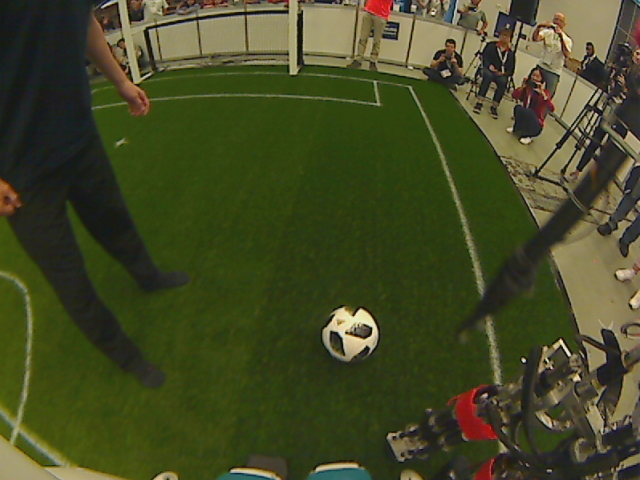

In [1091]:
TF.to_pil_image(invTrans(ds[i][0]))

## Expected Segmentation output

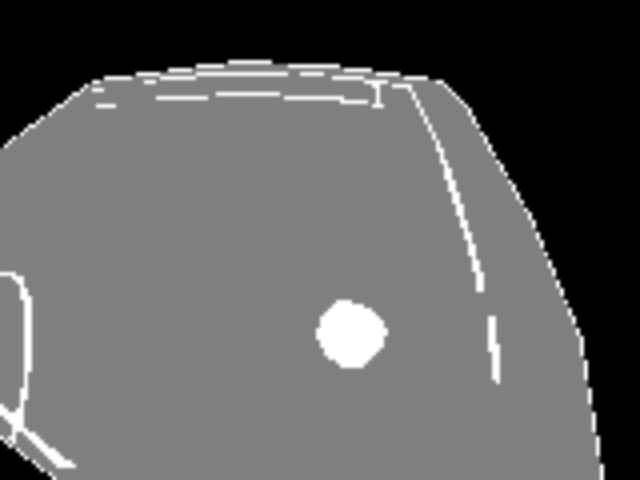

In [1092]:
TF.resize(TF.to_pil_image(ds[i][1]/2),(480,640))

## Output Produced

In [1093]:
seg,blob = nimbro_net(ds[i][0].unsqueeze(0).cuda())

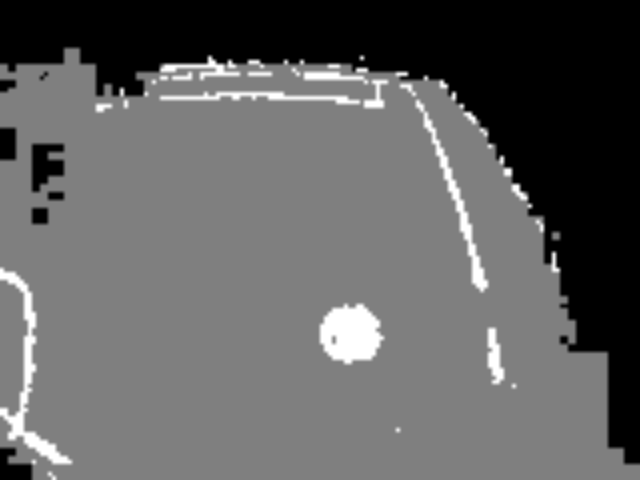

In [1094]:
TF.resize(TF.to_pil_image(seg.cpu()[0].argmax(0)/2.0),(480,640))

## Robot Detection

tensor(0.6018, grad_fn=<MaxBackward1>)


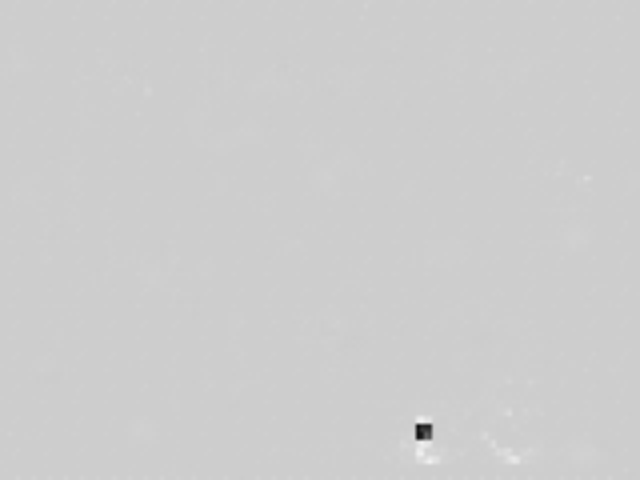

In [84]:
print((blob.cpu()[0,2]).max())
TF.resize(TF.to_pil_image((blob.cpu()[0,2]-0.2)),(480,640)) # after threshholdin

## Goal Post Detection

tensor(0.7412, grad_fn=<MaxBackward1>)


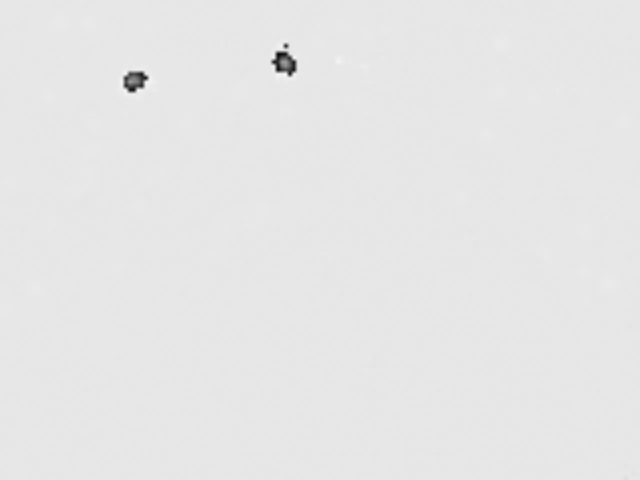

In [85]:
print((blob.cpu()[0,1]).max())
TF.resize(TF.to_pil_image((blob.cpu()[0,1]-0.1)),(480,640)) # after threshholdin

## Ball Detection

tensor(0.9316, grad_fn=<MaxBackward1>)


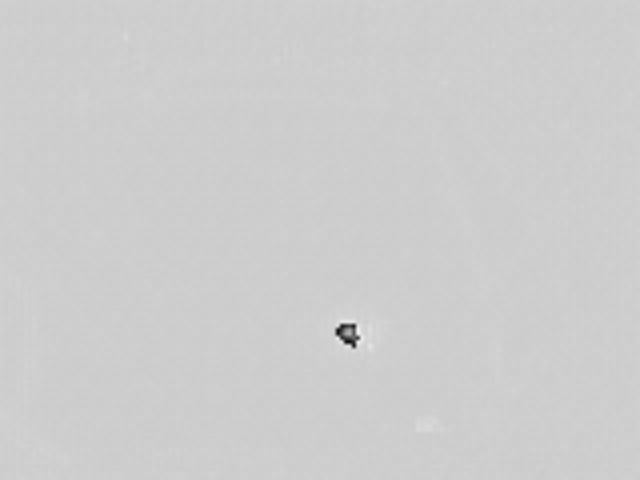

In [1102]:
print((blob.cpu()[0,0]).max())
TF.resize(TF.to_pil_image((blob.cpu()[0,0]-0.2)),(480,640)) # after threshholdin

In [247]:
torch.save(nimbro_net.state_dict(), './model2-6Mar')

# Loss Visualisation

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt


In [56]:
mse_val_loss = [loss[0] for loss in val_losses]
var_blob = [loss[1].item() for loss in val_losses]
nll = [loss[2] for loss in val_losses]
var_seg = [loss[3].item() for loss in val_losses]

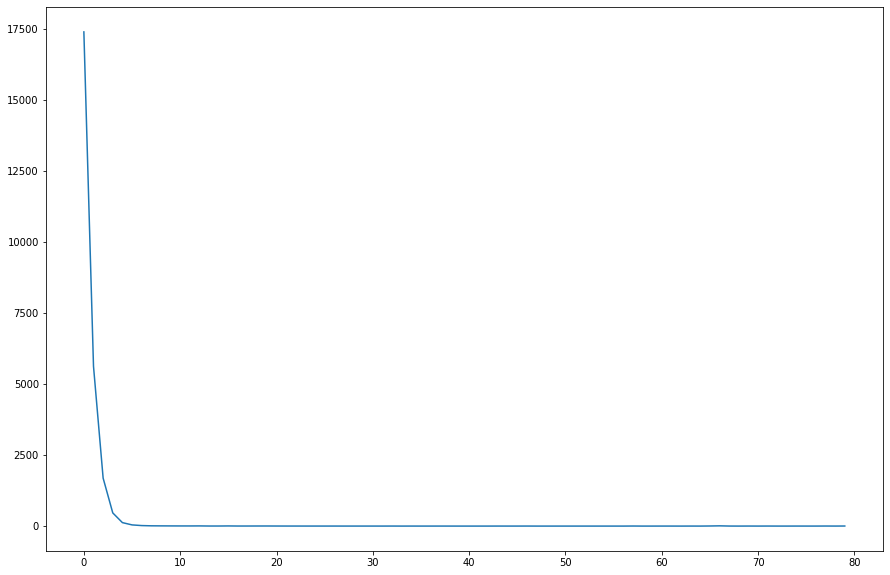

In [57]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(mse_val_loss[:]))
plt.show()

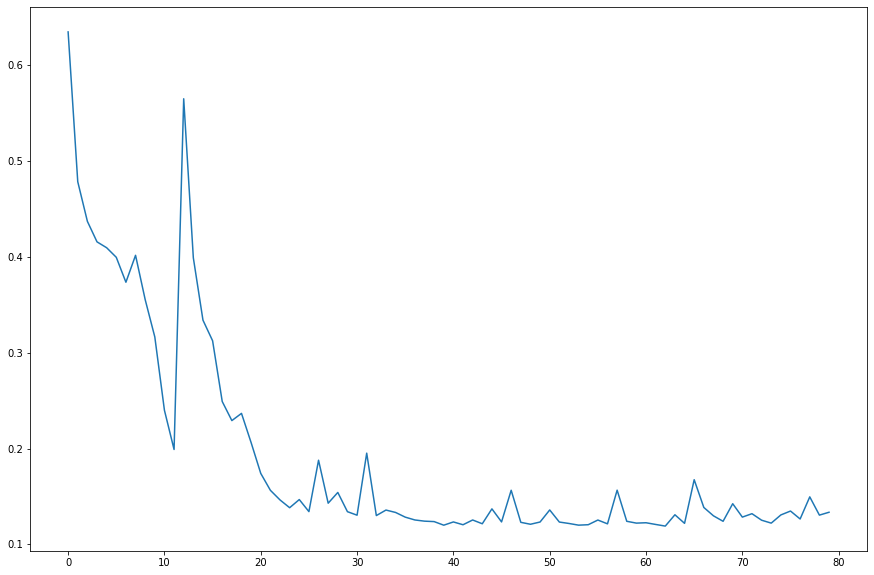

In [58]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(nll))
plt.show()

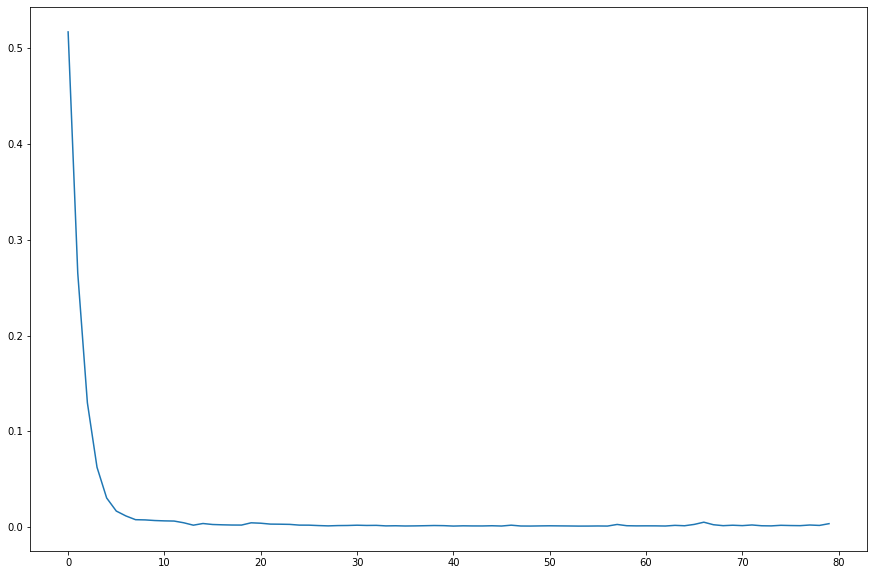

In [248]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_blob[:]))
plt.show()

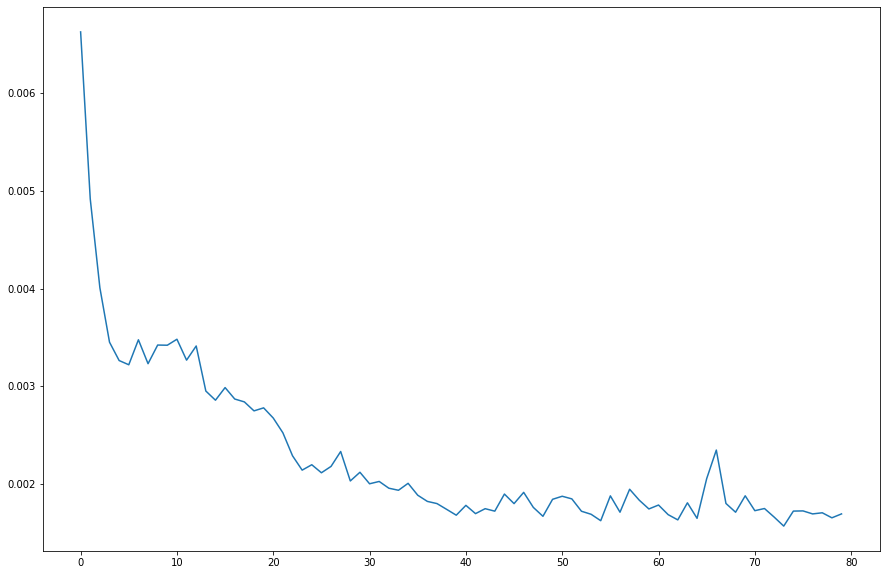

In [60]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_seg))
plt.show()

# Accuracy and IoU on Segmentation Head

In [394]:
nimbro_net.eval()
# storing counts for true count, correct count and predicted count
class_accuracy = {'Background':[0,0,0],'Field':[0,0,0],'Line':[0,0,0]}
for k,(images, target) in enumerate(val_seg_loader):

    images = images.cuda()

    seg,_ = nimbro_net(images)
    seg_classes = seg.cpu().argmax(1)
    
    for label,class_ in enumerate(class_accuracy):
        class_accuracy[class_][0] += (target == label).sum().item()
        class_accuracy[class_][1] += ((target == label) & (seg_classes == label) ) .sum().item()
        class_accuracy[class_][2] += (seg_classes == label).sum().item()

In [395]:
class_accuracy

{'Background': [869405, 844477, 874173],
 'Field': [1724515, 1682867, 1732561],
 'Line': [132480, 93661, 119666]}

In [396]:
iou_sum = 0
accuracy_sum = 0
for label,val in class_accuracy.items():
    print(f'{label}    \tAccuracy:{val[1]/val[0]:.3f},   \tIoU:{val[1]/(val[0]+val[2]-val[1]):.3f}')
    accuracy_sum += val[1]/val[0]
    iou_sum += val[1]/(val[0]+val[2]-val[1])

Background    	Accuracy:0.971,   	IoU:0.939
Field    	Accuracy:0.976,   	IoU:0.949
Line    	Accuracy:0.707,   	IoU:0.591


In [397]:
print(f'Average Accuracy {accuracy_sum/3:.3f}, Average IoU:{iou_sum/3:.3f}')

Average Accuracy 0.885, Average IoU:0.826


# Accuracy, Precision, Recall and other mertrics on Detection Head

In [1066]:
def get_modes(matrix,threshold_prob=0.2,threshold_sum=3):
    points = []
    max_val = matrix.max()
    while max_val > threshold_prob:
        i,j = np.unravel_index(matrix.argmax(),matrix.shape)
        if matrix[max(-5+i,0):min(5+i,matrix.shape[0]-1),max(-5+j,0):min(5+j,matrix.shape[1]-1)].sum().item() > threshold_sum:
            points.append((i,j))
        matrix[max(-5+i,0):min(5+i,matrix.shape[0]),max(-5+j,0):min(5+j,matrix.shape[1])] = 0
        max_val = matrix.max()
    return points

In [1067]:
nimbro_net.eval()
true = [0,0,0]
correct = [0,0,0]
pred = [0,0,0]
for i in range(1,len(test_dataset)):
    
    seg,blob = nimbro_net(test_dataset[i][0].unsqueeze(0).cuda())
    target = test_dataset[i][1]
    for channel in range(3):
        true_dets = get_modes(target.numpy().copy()[channel],threshold_prob=0.6,threshold_sum=4)
        pred_dets = get_modes(blob[0,channel].cpu())
        true[channel] = true[channel] + len(true_dets)
        pred[channel] = pred[channel] +  len(pred_dets)
        for p_det in pred_dets:
            for det in true_dets:
                if abs(det[0]-p_det[0]) <= 5 and abs(det[1]-p_det[1]) <=5:
                    correct[channel] = correct[channel] + 1
                    break
        
        
    

In [1072]:
channel_to_label={0:'Ball', 1:'Goal Post', 2:'Robot'}

In [1088]:
for channel,label in channel_to_label.items():
    print(f'{label}    \tAccuracy:{correct[channel]/true[channel]:.2f}')
    precision = correct[channel]/pred[channel]
    print(f'\t\tPrecision:{precision:.2f}')
    recall = correct[channel]/(correct[channel]+true[channel]-pred[channel])
    print(f'\t\tRecall:{recall:.2f}')
    print(f'\t\tF1 Score:{2*precision*recall/(precision+recall):.2f}')
    print(f'\t\tFDR:{1-precision:.2f}')
    print('------------------------------------------')


Ball    	Accuracy:0.70
		Precision:0.97
		Recall:0.71
		F1 Score:0.82
		FDR:0.03
------------------------------------------
Goal Post    	Accuracy:0.73
		Precision:0.95
		Recall:0.76
		F1 Score:0.84
		FDR:0.05
------------------------------------------
Robot    	Accuracy:0.85
		Precision:0.85
		Recall:0.99
		F1 Score:0.92
		FDR:0.15
------------------------------------------
